In [0]:
import gdown
import time
import os
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (
    Dataset, 
    DataLoader,
)
from torchvision import transforms, models

In [30]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [31]:
!ls /content/gdrive/My\ Drive

'9.1.1 - Introduction.gdoc'
'9.1.1 - StoryBoard.gdoc'
 Backups
'Chapter 9.2.4 - Storyboard.gdoc'
'Colab Notebooks'
'Copy of CV - January 10, 2:03 PM.gdoc'
'Copy of DataDescription.gdoc'
'Copy of Emergency Contacts.gsheet'
'Copy of Read : Introduction to the Module.ipynb'
'Copy of RNN project 2nd Arch.ipynb'
 CV.gdoc
'DL Deployment'
'DL in Production.gdoc'
'EMD presentation - May 19.gslides'
'Emotion Detection - May 15, 2020 - Bar chart 1.gsheet'
 Fuse.AI
 LinuxDocs
'LSTM Reading'
 Managerial
'ML Group Review.gdoc'
'ML Group Review.gsheet'
'ML Questions .gsheet'
'Module 2 TODO.gdoc'
'Module - 9 : Storyboard.gdoc'
 music_generation
'Object Detection'
'Object Detection.ipynb'
'One-on-One Meeting.gdoc'
'Proposal Guidelines.gslides'
'Psychological Safety - Case Study.gdoc'
 TECH-MLComponents-070520-0631.gdoc
 TECH-MLProjectIssueTypes-070520-0631.gdoc
 Training
'Untitled document.gdoc'


In [32]:
import tarfile

# https://drive.google.com/open?id=12eYPcI_3sKhOauUkUdrjzqE_ri9V0jGT
# https://drive.google.com/file/d/1lYTu5qkbHUvoIJysxxTuq5vj9H1vj7dD/view?usp=sharing

files = {
    'train': ('trainset.tar.gz', f'https://drive.google.com/uc?id=1lYTu5qkbHUvoIJysxxTuq5vj9H1vj7dD'),
    'test': ('testset.tar.gz', f'https://drive.google.com/uc?id=1kN1RZC1QjuR_U8Ttbjm_kSDfYp1cGzYn')
}

for tname, (tfname, turl) in files.items():
    if not os.path.exists(tfname):
        print(f'Downloading {tname}ing file.')
        gdown.download(turl, tfname, quiet=False)
        tar = tarfile.open(tfname, 'r:gz')
        tar.extractall()
        tar.close()
    else:
        print(f'{tname}ing file already exists.')

training file already exists.
testing file already exists.


In [0]:
class BallotPaperDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_name = os.path.join(self.root_dir, self.df.iloc[idx, 0])

        image = io.imread(image_name)

        if self.transform:
            image = self.transform(image)

        sample = {'image': image, 'label': self.df.iloc[idx, 1]}

        return sample

In [34]:
from sklearn.model_selection import train_test_split

df_train = pd.read_csv('trainset.csv')
df_test = pd.read_csv('testset.csv')

df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=18)

data_transform = transforms.Compose([
                                     transforms.ToPILImage(),
                                    #  transforms.Resize(320),
                                    #  transforms.CenterCrop(224),
                                     transforms.RandomGrayscale(p=0.4),
                                     transforms.RandomHorizontalFlip(p=0.5),
                                    #  transforms.RandomRotation(60),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                ])

dataset_train = BallotPaperDataset(df_train, root_dir=f'./trainset/', transform=data_transform)
dataset_val = BallotPaperDataset(df_val, root_dir=f'./trainset/', transform=data_transform)
dataset_test = BallotPaperDataset(df_test, root_dir=f'./testset/', transform=data_transform)

datasets = {
    'train': dataset_train,
    'val': dataset_val,
    'test': dataset_test,
}

dataset_sizes = {x: len(k) for x, k in datasets.items()}

print(dataset_sizes)

{'train': 7680, 'val': 1920, 'test': 2609}


In [0]:
def visualize_sample(dataset, n=8, ncols=4, figsize=(20, 4), random_state=None):
    nrows = int(np.ceil(n/ncols))
    fig = plt.figure(figsize=figsize)

    if random_state:
        np.random.seed(random_state)

    randints = np.random.randint(0, len(dataset), size=n)

    for i, idx in enumerate(randints):
        sample = dataset[idx]
        ax = plt.subplot(nrows, ncols, i+1)
        plt.tight_layout()
        ax.axis('off')
        ax.set_title(f'Label: {sample["label"]}')
        # print(type(sample['image']))
        plt.imshow(sample['image'].permute(1, 2, 0))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


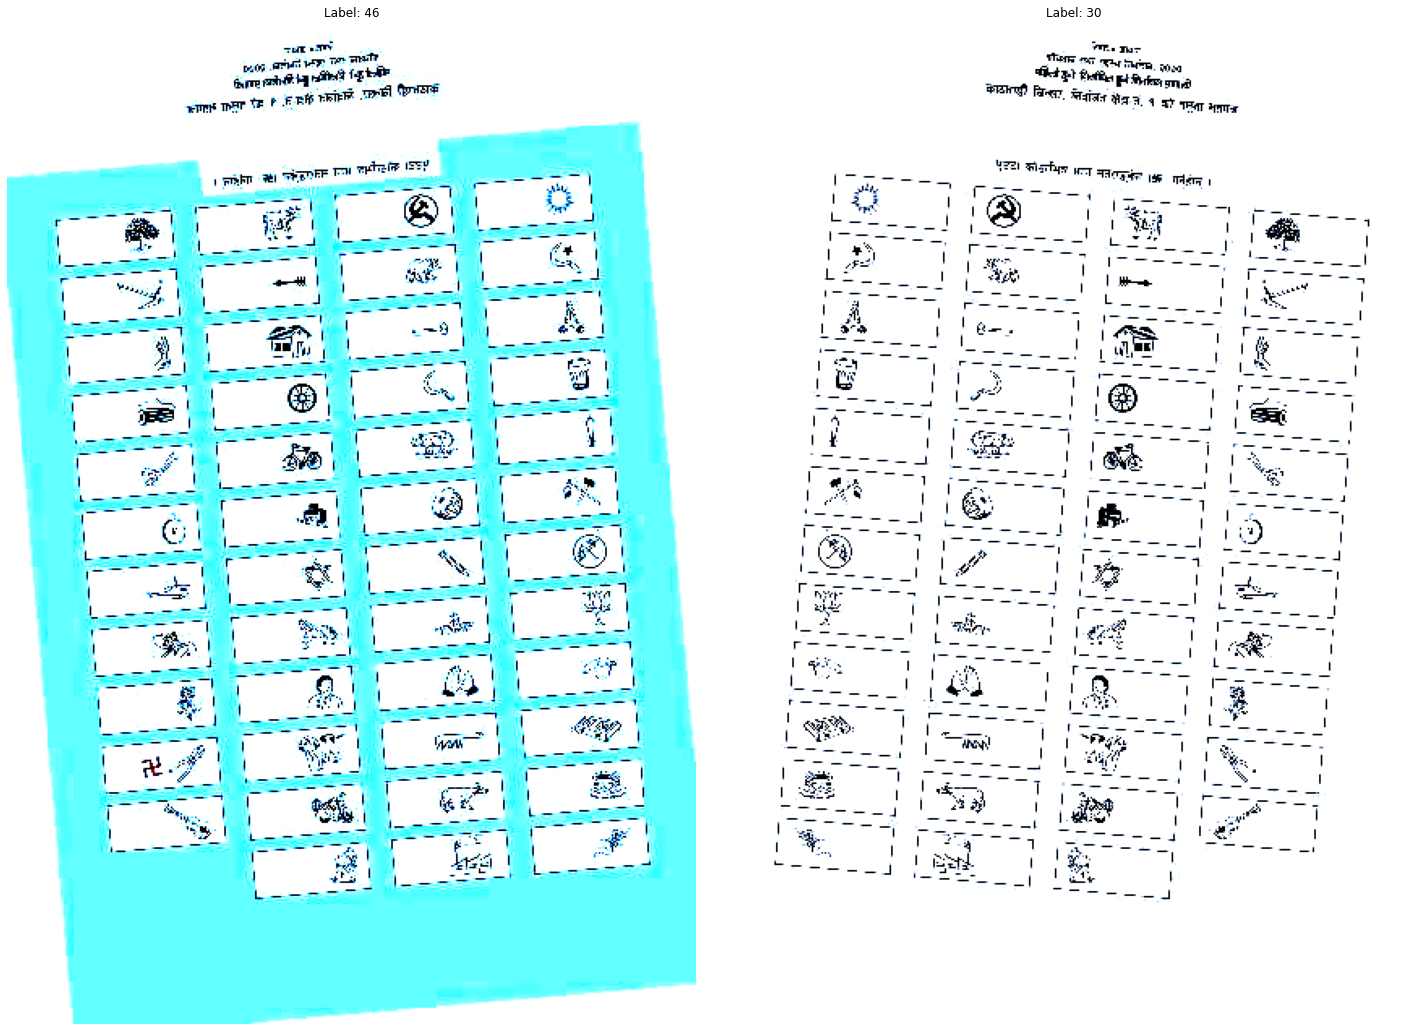

In [36]:
visualize_sample(datasets['train'], n=2, ncols=2, figsize=(20, 15), random_state=19)

In [37]:
sample = datasets['train'][0]
sample['image'].shape

torch.Size([3, 618, 425])

In [38]:
BS = 8

data_loaders = {x: DataLoader(k, batch_size=BS, shuffle=True) for x, k in datasets.items()}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [0]:
def time_string(second):
    second_int = int(second)
    hour = second_int//(60 * 60)
    minute = (second_int - (hour * 3600))//60
    second = second % 60
    if hour > 0:
        return f'{hour:02}h:{minute:02}m:{second:02.2f}s'
    elif minute > 0:
        return f'{minute:02}m:{second:02.2f}s'
    else:
        return f'{second:02.2f}s'

In [0]:
def train(model, optimizer, criterion, num_epochs, device):
    start_time = time.time()

    best_val_acc = -float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        i_batch = 0

        train_loss = 0.0
        true_preds = 0

        model.train()
        for sample_batch in data_loaders['train']:
            optimizer.zero_grad()
            model.train()
            i_batch += 1

            x_train = sample_batch['image'].to(device)
            y_train = sample_batch['label'].to(device)

            y_hat = model(x_train)
            # y_hat = torch.log_softmax(y_hat, dim=1)
            # print(y_hat)
            loss = criterion(y_hat, y_train)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            y_pred = torch.argmax(y_hat, dim=1)

            true_pred = torch.sum(y_pred == y_train)
            # print(f'Mini-batch: {i_batch} | True pred: {true_pred} | Batch acc: {100*true_pred/BS:.2f}%')

            true_preds += true_pred

        train_acc = true_preds.double()/dataset_sizes['train']
        train_loss /= dataset_sizes['train']

        # with torch.no_grad():
        model.eval()
        val_loss = 0.0
        true_preds = 0
        for sample_val_set in data_loaders['val']:
            sample_val_x = sample_val_set['image'].to(device)
            sample_val_y = sample_val_set['label'].to(device)

            y_val_hat = model(sample_val_x)
            # y_test_hat = torch.log_softmax(y_test_hat, dim=1)

            val_loss += criterion(y_val_hat, sample_val_y)

            y_val_pred = torch.argmax(y_val_hat, dim=1)

            true_preds += torch.sum(sample_val_y == y_val_pred)

        val_loss /= dataset_sizes['val']
        val_acc = true_preds.double() / dataset_sizes['val']

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), '/content/gdrive/My Drive/Training/resnet50-model_v1.1.pt')
        
        print(f'\tTrain Loss: {train_loss:.5f} | Val Accuracy: {100 * train_acc:.2f}%')
        print(f'\tTest  Loss: {test_loss:.5f} | Val  Accuracy: {100 * test_acc:.2f}%')

In [0]:
N_CLASSES = 48

model = models.resnet50(pretrained=True)

# for param in model.parameters():
#     param.requires_grad = False


num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(num_features, N_CLASSES, bias=True),
)

model.to(device)

optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.01)

criterion = nn.CrossEntropyLoss()

In [42]:
sample = next(iter(data_loaders['train']))
X, y = sample['image'], sample['label']

X = X.to(device)
y = y.to(device)

print(X.dtype, y.dtype)
print(X.size(), y.size())

for i in range(1000):
    optimizer.zero_grad()
    y_pred = model(X)

    loss = criterion(y_pred, y)

    loss.backward()
    optimizer.step()

    y_hat = torch.argmax(y_pred, dim=1)

    acc = torch.sum(y_hat == y).double() / y.size(0)

    if i % 30 == 0:
        print(f'Accuracy: {acc:.3f}')

torch.float32 torch.int64
torch.Size([8, 3, 618, 425]) torch.Size([8])


RuntimeError: ignored

In [0]:
N_EPOCHS = 10

train(model, optimizer, criterion, N_EPOCHS, device)